
# Load PyTorch model

In this tutorial, you learn how to load an existing PyTorch model and use it to run a prediction task.

We will run the inference in DJL way with [example](https://pytorch.org/hub/pytorch_vision_resnet/) on the pytorch official website.


## Preparation

This tutorial requires the installation of Java Kernel. For more information on installing the Java Kernel, see the [README](https://github.com/deepjavalibrary/djl/blob/master/jupyter/README.md).

In [1]:
// %mavenRepo snapshots https://oss.sonatype.org/content/repositories/snapshots/

%maven ai.djl:api:0.22.1
%maven ai.djl.pytorch:pytorch-engine:0.22.1
%maven org.slf4j:slf4j-simple:1.7.32

In [2]:
import java.nio.file.*;
import java.awt.image.*;
import ai.djl.*;
import ai.djl.inference.*;
import ai.djl.modality.*;
import ai.djl.modality.cv.*;
import ai.djl.modality.cv.util.*;
import ai.djl.modality.cv.transform.*;
import ai.djl.modality.cv.translator.*;
import ai.djl.repository.zoo.*;
import ai.djl.translate.*;
import ai.djl.training.util.*;

## Step 1: Prepare your  model

This tutorial assumes that you have a TorchScript model.
DJL only supports the TorchScript format for loading models from PyTorch, so other models will need to be [converted](https://github.com/deepjavalibrary/djl/blob/master/docs/pytorch/how_to_convert_your_model_to_torchscript.md).
A TorchScript model includes the model structure and all of the parameters.

We will be using a pre-trained `resnet18` model. First, use the `DownloadUtils` to download the model files and save them in the `build/pytorch_models` folder

In [3]:
DownloadUtils.download("https://djl-ai.s3.amazonaws.com/mlrepo/model/cv/image_classification/ai/djl/pytorch/resnet/0.0.1/traced_resnet18.pt.gz", "build/pytorch_models/resnet18/resnet18.pt", new ProgressBar());

In order to do image classification, you will also need the synset.txt which stores the classification class labels. We will need the synset containing the Imagenet labels with which resnet18 was originally trained.

In [4]:
DownloadUtils.download("https://djl-ai.s3.amazonaws.com/mlrepo/model/cv/image_classification/ai/djl/pytorch/synset.txt", "build/pytorch_models/resnet18/synset.txt", new ProgressBar());

## Step 2: Create a Translator

We will create a transformation pipeline which maps the transforms shown in the [PyTorch example](https://pytorch.org/hub/pytorch_vision_resnet/).
```python
...
preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
...
```

Then, we will use this pipeline to create the [`Translator`](https://javadoc.io/doc/ai.djl/api/latest/ai/djl/translate/Translator.html)

In [5]:
Translator<Image, Classifications> translator = ImageClassificationTranslator.builder()
        .addTransform(new Resize(256))
        .addTransform(new CenterCrop(224, 224))
        .addTransform(new ToTensor())
        .addTransform(new Normalize(
            new float[] {0.485f, 0.456f, 0.406f},
            new float[] {0.229f, 0.224f, 0.225f}))
        .optApplySoftmax(true)
        .build();

## Step 3: Load your model

Next, we add some search criteria to find the resnet18 model and load it. In this case, we need to tell `Criteria` where to locate the model by calling `.optModelPath()` API.

In [6]:
Criteria<Image, Classifications> criteria = Criteria.builder()
        .setTypes(Image.class, Classifications.class)
        .optModelPath(Paths.get("build/pytorch_models/resnet18"))
        .optOption("mapLocation", "true") // this model requires mapLocation for GPU
        .optTranslator(translator)
        .optProgress(new ProgressBar()).build();

ZooModel model = criteria.loadModel();

Loading:     100% |████████████████████████████████████████|


[IJava-executor-0] INFO ai.djl.pytorch.engine.PtEngine - PyTorch graph executor optimizer is enabled, this may impact your inference latency and throughput. See: https://docs.djl.ai/docs/development/inference_performance_optimization.html#graph-executor-optimization
[IJava-executor-0] INFO ai.djl.pytorch.engine.PtEngine - Number of inter-op threads is 3
[IJava-executor-0] INFO ai.djl.pytorch.engine.PtEngine - Number of intra-op threads is 6


## Step 4: Load image for classification

We will use a sample dog image to run our prediction on.

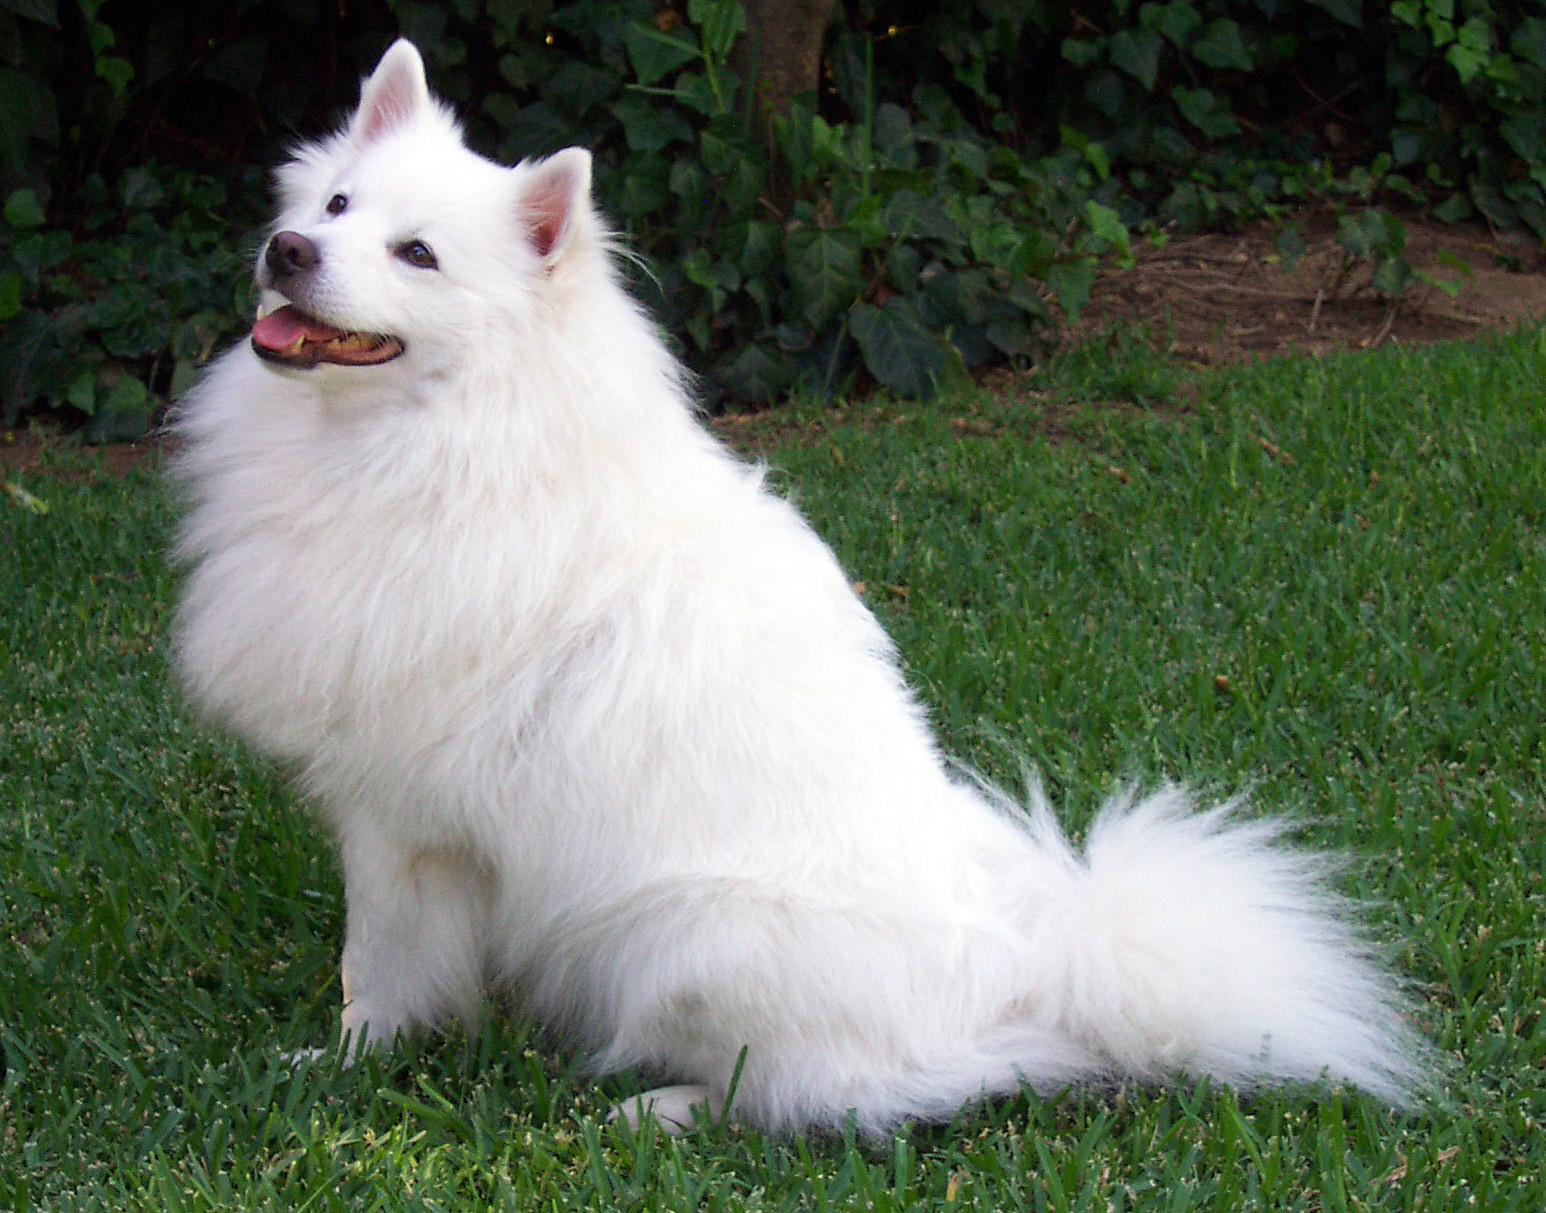

In [7]:
var img = ImageFactory.getInstance().fromUrl("https://raw.githubusercontent.com/pytorch/hub/master/images/dog.jpg");
img.getWrappedImage()

## Step 5: Run inference

Lastly, we will need to create a predictor using our model and translator. Once we have a predictor, we simply need to call the predict method on our test image.

In [8]:
Predictor<Image, Classifications> predictor = model.newPredictor();
Classifications classifications = predictor.predict(img);

classifications

[
	{"class": "n02111889 Samoyed, Samoyede", "probability": 0.94256}
	{"class": "n02114548 white wolf, Arctic wolf, Canis lupus tundrarum", "probability": 0.02820}
	{"class": "n02111500 Great Pyrenees", "probability": 0.01032}
	{"class": "n02120079 Arctic fox, white fox, Alopex lagopus", "probability": 0.00412}
	{"class": "n02109961 Eskimo dog, husky", "probability": 0.00279}
]

## Summary

Now, you can load any TorchScript model and run inference using it.

You might also want to check out [load_mxnet_model.ipynb](https://github.com/deepjavalibrary/djl/blob/master/jupyter/load_mxnet_model.ipynb) which demonstrates loading a local model directly instead of through the Model Zoo API.
To optimize inference performance, you might check out [how_to_optimize_inference_performance](https://github.com/deepjavalibrary/djl/blob/master/docs/pytorch/how_to_optimize_inference_performance.md).